# Import Packages and Tables

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot
import io

!pip install statsmodels --upgrade
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

!pip install arch
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving btc daily price.csv to btc daily price.csv
Saving fed rates.csv to fed rates.csv
Saving nasdaq.csv to nasdaq.csv
Saving gold price.csv to gold price.csv
Saving Gold Spot.csv to Gold Spot.csv


# Data Preprocessing

In [ ]:
btc = pd.read_csv(io.BytesIO(uploaded['btc daily price.csv']))
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.sort_values(by=['Date'],ascending=True)
btc.head()

,Date,Price
3879,2011-01-01,0.3
3878,2011-01-02,0.3
3877,2011-01-03,0.3
3876,2011-01-04,0.3
3875,2011-01-05,0.3


In [ ]:
# converting monthly fed rates into daily
fed = pd.read_csv(io.BytesIO(uploaded['fed rates.csv']))
fed['month'] = pd.to_datetime(fed['Date'], format='%Y-%m')
fed = fed.pivot(index='month', columns='fed')

start_date = fed.index.min() - pd.DateOffset(day=1)
end_date = fed.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
fed = fed.reindex(dates, method='ffill')

fed = fed.stack('fed')
fed = fed.sort_index()
fed = fed.reset_index()
fed = fed.drop(['Date'],axis=1)
fed = fed.rename({'date':'Date'})
fed.head()

,date,fed
0,1960-01-31,3.99
1,1960-02-01,3.99
2,1960-02-02,3.99
3,1960-02-03,3.99
4,1960-02-04,3.99


In [ ]:
nasdaq = pd.read_csv(io.BytesIO(uploaded['nasdaq.csv']))
nasdaq['Date'] = pd.to_datetime(nasdaq['Exchange Date'])
nasdaq = nasdaq.drop(['Exchange Date'],axis=1)
nasdaq = nasdaq.rename(columns={"Close": "nasdaq"})
nasdaq.head()

,nasdaq,Net,%Chg,Open,Low,High,Volume,Date
0,15098.43,-83.20,-0.0055,15125.74,15063.02,15162.34,84374904,2021-08-06
1,15181.64,98.25,0.0065,15105.40,15083.84,15184.27,152624365,2021-08-05
2,15083.39,21.97,0.0015,15059.17,15017.14,15117.38,193179867,2021-08-04
3,15061.42,97.80,0.0065,14997.20,14864.53,15063.66,166865870,2021-08-03
4,14963.62,3.73,0.0002,15046.10,14945.13,15059.89,157331338,2021-08-02


In [ ]:
gold_price = pd.read_csv(io.BytesIO(uploaded['gold price.csv']))
gold_price['Date'] = pd.to_datetime(gold_price['Exchange Date'])
gold_price = gold_price.drop(['Exchange Date'],axis=1)
gold_price = gold_price.rename(columns={"Close": "Gold Price"})
gold_price.head()

,Gold Price,Net,Volume,Date
0,1760.0,-45.1,825,2021-08-06
1,1805.1,-5.4,588,2021-08-05
2,1810.5,0.4,2860,2021-08-04
3,1810.1,-8.0,3341,2021-08-03
4,1818.1,5.5,1334,2021-08-02


In [ ]:
gold_spot = pd.read_csv(io.BytesIO(uploaded['Gold Spot.csv']))
gold_spot['Date'] = pd.to_datetime(gold_spot['Exchange Date'])
gold_spot = gold_spot.drop(['Exchange Date'],axis=1)
gold_spot = gold_spot.rename(columns={"Close": "gold_spot"})
gold_spot.head()

,gold_spot,Net,%Chg,Open,Low,High,Date
0,1763.10,-40.9131,-0.0227,1804.01,1757.70,1804.57,2021-08-06
1,1804.01,-7.3919,-0.0041,1811.39,1797.20,1814.90,2021-08-05
2,1811.41,1.4651,0.0008,1810.35,1806.16,1831.51,2021-08-04
3,1809.94,-3.4451,-0.0019,1813.38,1806.00,1814.76,2021-08-03
4,1813.39,-0.1965,-0.0001,1813.89,1804.49,1819.43,2021-08-02


# EDA and Pre-tests

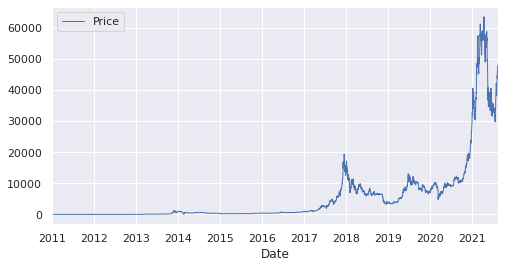

In [ ]:
btc_price = btc[['Date','Price']]
btc_price = btc_price.set_index(['Date'])
sns.set(rc={'figure.figsize':(8, 4)})
btc_price.plot(linewidth=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


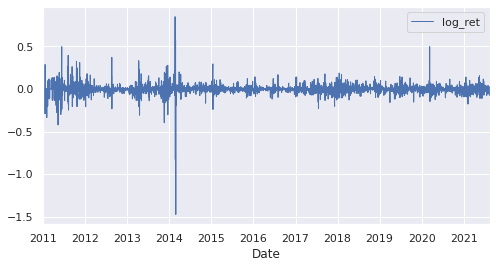

In [ ]:
btc['pct_change'] = btc.Price.pct_change()
btc['log_ret'] = np.log(btc.Price) - np.log(btc.Price.shift(1))
btc['log_ret'][0]=0
btc['log_price'] = np.log(btc.Price)
btc_return = btc[['Date','log_ret']]
btc_return = btc_return.set_index(['Date'])
sns.set(rc={'figure.figsize':(8, 4)})
btc_return.plot(linewidth=1)

In [ ]:
#ADF Test

from statsmodels.tsa.stattools import adfuller
X = btc.Price
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.535592
p-value: 0.107053
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
#ADF Test

from statsmodels.tsa.stattools import adfuller

X = btc.log_ret
result = adfuller(X)
X.fillna(0)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.637263
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


# ARIMA on log Return diff

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
btc_return = btc_return.sort_index()
train = btc_return[0:-1001]
test = btc_return[-1001:-1]

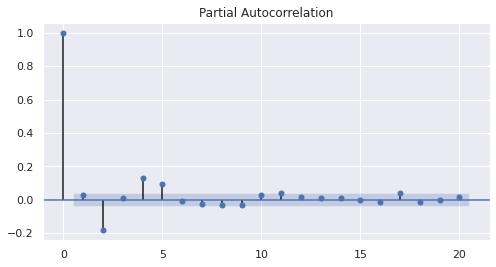

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train,lags=20)
pyplot.show()

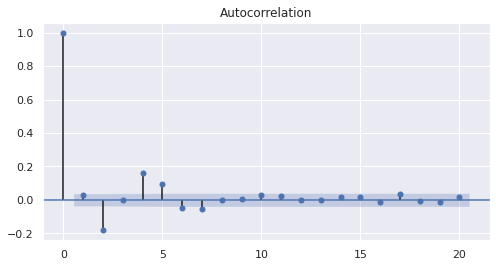

In [ ]:
plot_acf(train,lags=20)
pyplot.show()

## Auto ARIMA

In [ ]:
arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
                         max_p=8, max_d=5, max_q=8,
                         m = 12, seasonal = True,
                         start_P=0, D=0, start_Q=0,
                         max_P=3, max_D=1, max_Q=3,
                         error_action ='warn',trace = True,
                         supress_warnings=True, stepwise=True,
                         random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-8018.038, Time=0.34 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-8015.880, Time=2.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-8016.853, Time=3.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-8012.252, Time=0.15 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-8016.043, Time=2.17 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-8016.043, Time=1.50 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-8014.043, Time=1.95 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-8017.869, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-8018.839, Time=0.81 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-8016.853, Time=2.39 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-8014.853, Time=4.20 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-8039.972, Time=1.97 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-8037.979, Time=5.95 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-8037.979, Time=6.23 sec
 ARIM

In [ ]:
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3079
Model:               SARIMAX(2, 0, 0)   Log Likelihood                4059.071
Date:                Mon, 16 Aug 2021   AIC                          -8110.143
Time:                        09:46:41   BIC                          -8086.013
Sample:                             0   HQIC                         -8101.475
                               - 3079                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.001     -3.052      0.002      -0.006      -0.001
ar.L1          0.0286      0.009      3.264      0.001       0.011       0.046
ar.L2         -0.1737      0.006    -30.793      0.0

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=800),index=test.index)
prediction.columns = ['predicted BTC log returns']
prediction

,predicted BTC log returns
Date,
2019-06-07,-0.004390
2019-06-08,0.000495
2019-06-09,-0.003015
2019-06-10,-0.003965
2019-06-11,-0.003382
...,...
2021-08-10,-0.003312
2021-08-11,-0.003312
2021-08-12,-0.003312


## Mannual ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt


# fit model
model = ARIMA(train, order=(4,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                 2879
Model:                 ARIMA(4, 1, 1)   Log Likelihood                3750.013
Date:                Mon, 16 Aug 2021   AIC                          -7488.027
Time:                        11:34:53   BIC                          -7452.238
Sample:                    01-01-2011   HQIC                         -7475.126
                         - 11-18-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0308      0.010      3.207      0.001       0.012       0.050
ar.L2         -0.1572      0.006    -24.545      0.000      -0.170      -0.145
ar.L3          0.0025      0.010      0.249      0.8

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
output = pd.DataFrame(model_fit.forecast(steps = 100))
output

,predicted_mean
2018-11-19,0.005966
2018-11-20,-0.024131
2018-11-21,-0.003641
2018-11-22,0.021404
2018-11-23,0.000458
...,...
2019-02-22,-0.001500
2019-02-23,-0.001500
2019-02-24,-0.001500
2019-02-25,-0.001500


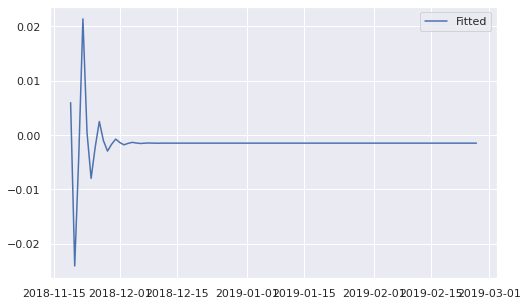

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(output,label='Fitted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

print('In-sample RMSE: ',np.sqrt(mean_squared_error(train,model_fit.fittedvalues)))
print("Out-of-sample RMSE: ",np.sqrt(mean_squared_error(test,output['predicted_mean'])))


In-sample RMSE:  0.06721182710252004
Out-of-sample RMSE:  0.03972295654279431


In [ ]:
ptg = pd.DataFrame(np.abs((test['log_ret'] - output['predicted_mean']))/np.abs(test['log_ret']))
ptg.replace([np.inf, -np.inf], np.nan, inplace=True)
ptg = ptg.dropna()
ptg.mean()

0    1.611395
dtype: float64

# ARIMA NEW

##Importing necessary libraries

In [ ]:
import pandas as kunfu
import numpy as dragon
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

## Data Processing

<class 'pandas.core.frame.DataFrame'>
            Price
Date             
2011-01-01    0.3
2011-01-02    0.3
2011-01-03    0.3
2011-01-04    0.3
2011-01-05    0.3


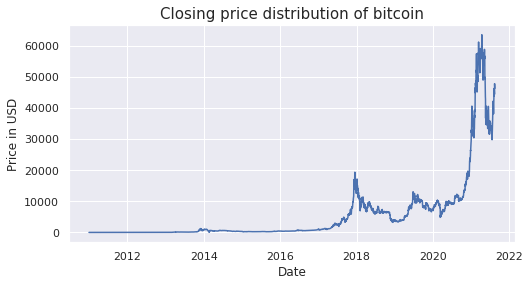

In [ ]:
btc_new = btc.copy()
data = btc_new['Price']
Date1 = btc_new['Date']
train1 = btc_new[['Date','Price']]
# Setting the Date as Index
train2 = train1.set_index('Date')
train2.sort_index(inplace=True)
print (type(train2))
print (train2.head())
plot.plot(train2)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title("Closing price distribution of bitcoin", fontsize=15)
plot.show()

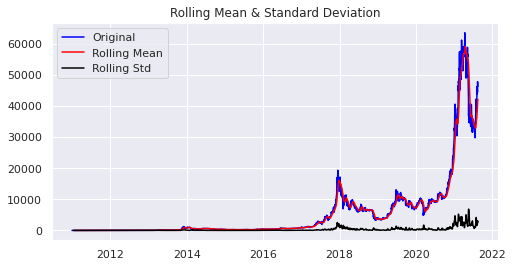

ADF Stastistic: 0.330864
p-value: 0.978717
The graph is non stationery
Critical values:
	1%: -3.432 
	5%: -2.862 
	10%: -2.567 


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train2['Price']      
test_stationarity(ts)

## Log Transforming the series

Log transformation is used to unskew highly skewed data. Thus helping in forecasting process.

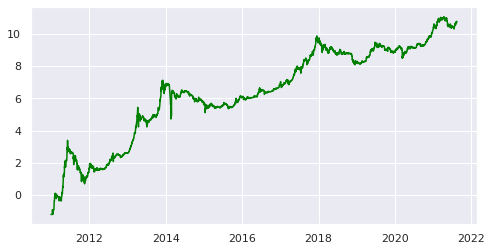

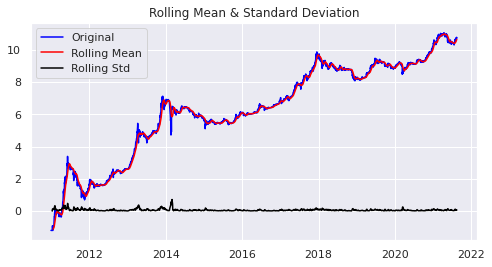

ADF Stastistic: -2.375052
p-value: 0.148902
The graph is non stationery
Critical values:
	1%: -3.432 
	5%: -2.862 
	10%: -2.567 


In [ ]:
ts_log = dragon.log(ts)
plot.plot(ts_log,color="green")
plot.show()

test_stationarity(ts_log)

##Remove trend and seasonality with differencing
In case of differencing to make the time series stationary the current value is subtracted with the previous values. Due to this the mean is stabilized and hence the chances of stationarity of time series are increased.

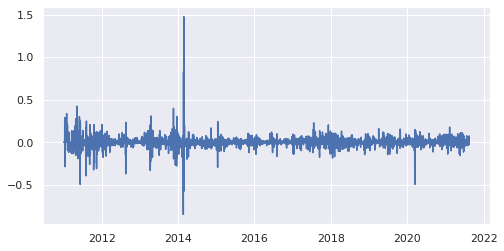

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

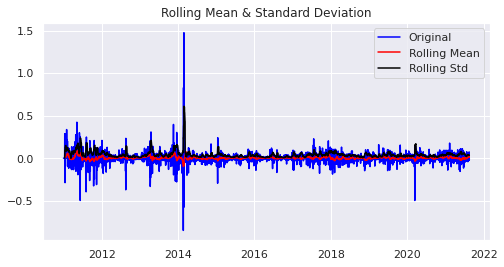

ADF Stastistic: -17.627147
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.432 
	5%: -2.862 
	10%: -2.567 


In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Auto Regressive model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

size = int(len(ts_log)-800)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')

Printing Predicted vs Expected Values...




/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted = 7903.818291,   expected = 7901.400000,   error = 0.030606  %
predicted = 7864.817598,   expected = 7635.000000,   error = 3.010054  %
predicted = 7678.005022,   expected = 7987.800000,   error = 3.878352  %
predicted = 8084.640700,   expected = 7888.000000,   error = 2.492909  %
predicted = 7859.222535,   expected = 8133.100000,   error = 3.367442  %
predicted = 8139.453548,   expected = 8219.000000,   error = 0.967836  %
predicted = 8226.303764,   expected = 8656.100000,   error = 4.965241  %
predicted = 8702.519106,   expected = 8812.500000,   error = 1.248010  %
predicted = 8798.219613,   expected = 8962.500000,   error = 1.832975  %
predicted = 9012.969941,   expected = 9318.800000,   error = 3.281861  %
predicted = 9403.117076,   expected = 9080.600000,   error = 3.551715  %
predicted = 9117.427080,   expected = 9255.400000,   error = 1.490729  %
predicted = 9364.335477,   expected = 9517.000000,   error = 1.604124  %
predicted = 9580.948549,   expected = 10179.300000,

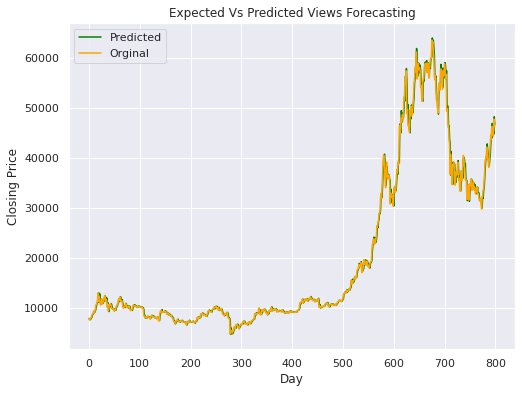

In [ ]:
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    original_value = test_arima[t]
    history.append(original_value)
    pred_value = dragon.exp(pred_value)
    original_value = dragon.exp(original_value)
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

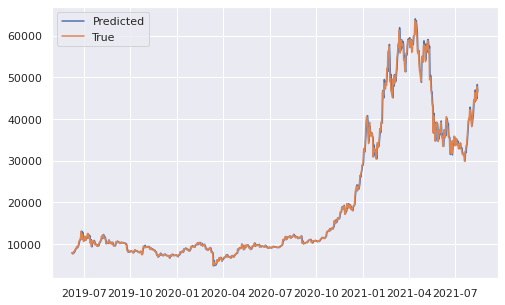

In [ ]:
import matplotlib.pyplot as plt
date = btc.Date[-800:]
og_price = btc.Price[-800:]
pred_true = pd.DataFrame({'Date':date,
                          'original':og_price,
                          'predicted':predictions})
pred_true = pred_true.set_index(['Date'])

plt.figure(figsize=(8,5))
plt.plot(pred_true['predicted'],label='Predicted')
plt.plot(pred_true['original'],label='True')
plt.legend()
plt.show()

In [ ]:
dragon.sqrt(mean_squared_error(pred_true['original'],pred_true['predicted']))

1139.8966084914823

In [ ]:
mean_absolute_error(pred_true['original'],pred_true['predicted'])

629.5482119258631

In [ ]:
ptg = pd.DataFrame(np.abs((pred_true['original'] - pred_true['predicted']))/np.abs(pred_true['original']))
ptg.replace([np.inf, -np.inf], np.nan, inplace=True)
ptg = ptg.dropna()
ptg.mean()*100

0    2.914178
dtype: float64

###In-sample Fitting

In [ ]:
train = [x for x in train_arima]

model_train = ARIMA(train, order=(5, 1, 0))
model_train_fit = model_train.fit(disp=-1)
print(model_train_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3079
Model:                 ARIMA(5, 1, 0)   Log Likelihood                4098.760
Method:                       css-mle   S.D. of innovations              0.064
Date:                Mon, 16 Aug 2021   AIC                          -8183.520
Time:                        15:10:14   BIC                          -8141.293
Sample:                             1   HQIC                         -8168.351
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      2.575      0.010       0.001       0.006
ar.L1.D.y      0.0168      0.018      0.936      0.349      -0.018       0.052
ar.L2.D.y     -0.1514      0.018     -8.508      0.0

In [ ]:
pred=model_train_fit.predict(typ='levels')
pred1 = []
orgn = []

for value in pred:
  pred1.append(dragon.exp(value))

for value in train_arima[1:]:
  orgn.append(dragon.exp(value))

train_p_t = pd.DataFrame({'original':orgn,
                          'pred':pred1})
train_p_t.dropna(inplace=True)
train_p_t

,original,pred
0,0.3,0.300992
1,0.3,0.300968
2,0.3,0.301137
3,0.3,0.301129
4,0.3,0.300982
...,...,...
3074,8124.8,8708.629051
3075,7685.5,8114.777771
3076,7779.1,7810.977065
3077,7784.9,7880.513385


In [ ]:
dragon.sqrt(mean_squared_error(train_p_t['original'],
                               train_p_t['pred']))

194.89025253677943

In [ ]:
mean_absolute_error(train_p_t['original'],train_p_t['pred'])

61.71007648112877

In [ ]:
ptg = pd.DataFrame(np.abs((train_p_t['original']-train_p_t['pred']))/np.abs(train_p_t['original']))
ptg.replace([np.inf, -np.inf], np.nan, inplace=True)
ptg = ptg.dropna()
ptg.mean()*100

0    3.400342
dtype: float64

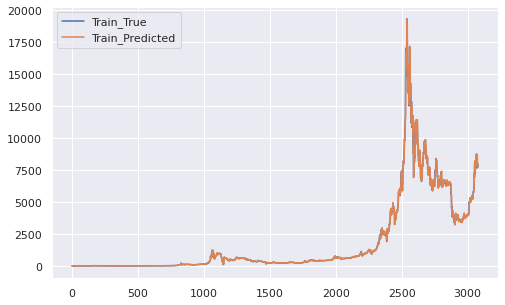

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(train_p_t['original'],label='Train_True')
plt.plot(train_p_t['pred'],label='Train_Predicted')
plt.legend()
plt.show()